# kitti dataset exploration

This note is used to explore dataset and develop corresponding tools that needed for visual odometry. It's mainly contain stereo vision, depth estimation and correction, feature detection and matching. Notes that in this project, all required path of folders and files are stored in `.env` and loaded with `load_dotenv` by `dotenv` packages. First, let's get the ground truth from the given `poses_file` file.

In [1]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dotenv import load_dotenv
from typing import Optional, Literal

load_dotenv()

poses = pd.read_csv(os.getenv("poses_file"), delimiter=' ', header=None)
poses.head().round(5)

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.00000,0.00000,0.00000,0.00000,0.00000,1.0,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
1,0.99998,0.00050,-0.00638,-0.00460,-0.00050,1.0,0.00031,-0.00200,0.00638,-0.00031,0.99998,0.09154
2,0.99991,0.00106,-0.01341,-0.01001,-0.00106,1.0,0.00021,-0.00436,0.01341,-0.00020,0.99991,0.18574
3,0.99978,0.00139,-0.02093,-0.01753,-0.00140,1.0,-0.00040,-0.00686,0.02093,0.00043,0.99978,0.28347
4,0.99955,0.00203,-0.03008,-0.02863,-0.00208,1.0,-0.00179,-0.00673,0.03008,0.00185,0.99955,0.38731


In each row, there are 12 number came from flattening a 3x4 transformation matrix of the left stereo camera `(P0)`. with respect to the global coordinate frame. The global frame is established the coordinate frame of the camera's first position.

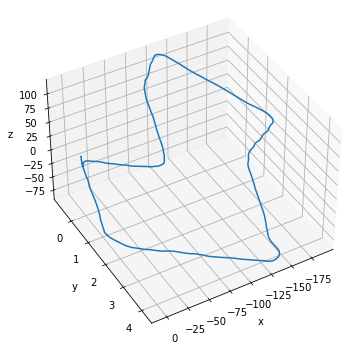

In [2]:
gt: np.ndarray = np.zeros((len(poses), 3, 4))
for i in range(len(poses)):
    gt[i] = np.array(poses.iloc[i]).reshape((3, 4))


fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(gt[:, :, 3][:, 0], gt[:, :, 3][:, 1], gt[:, :, 3][:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=40, azim=60)

Let's read the first image from the left camera.

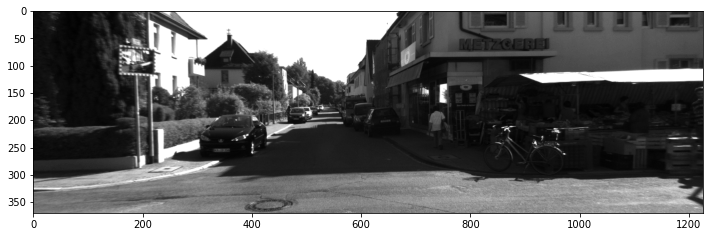

In [3]:
image = plt.imread(os.path.join(os.getenv("img_l_dir"), f"{'0'*10}.png"))
plt.figure(figsize=(12,6))
plt.imshow(image, cmap='gray')
plt.show()

## Camera Projection and Calibration

In [4]:
calib = pd.read_csv(os.getenv("calib_file") , delimiter=' ', header=None, index_col=0)
calib.head()

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
P0:,707.091200,0.000000,601.88730,0.000000,0.000000,707.091200,183.110400,0.000000,0.000000,0.000000,1.000000,0.000000
P1:,707.091200,0.000000,601.88730,-379.814500,0.000000,707.091200,183.110400,0.000000,0.000000,0.000000,1.000000,0.000000
P2:,707.091200,0.000000,601.88730,46.887830,0.000000,707.091200,183.110400,0.117860,0.000000,0.000000,1.000000,0.006203
P3:,707.091200,0.000000,601.88730,-333.459700,0.000000,707.091200,183.110400,1.930130,0.000000,0.000000,1.000000,0.003318
Tr:,-0.001858,-0.999966,-0.00804,-0.004784,-0.006481,0.008052,-0.999947,-0.073374,0.999977,-0.001806,-0.006496,-0.333997


In calibration file, we can obtain four `3x4` projection matrices for four position camera: `p0`, `p1`, `p2` and `p3`. And we can also obtain the transformation matrix for the LiDAR that denoted as `Tr`.

<div align='center'>
    <img src="../assets/kitti_schematic.png" width='600' alt='stereo' />
</div>

In [5]:

p0: np.ndarray = np.array(calib.loc['P0:']).reshape((3, 4))
p0

array([[707.0912,   0.    , 601.8873,   0.    ],
       [  0.    , 707.0912, 183.1104,   0.    ],
       [  0.    ,   0.    ,   1.    ,   0.    ]])

A projection matrix project three dimensional cooridnates in the global coordinates (world coordinates) onto two dimensional image plane (pixel coordinate)

$$
\begin{bmatrix}
    u \\ v \\ 1
\end{bmatrix} = \frac{1}{\lambda}P
\begin{bmatrix}
    x_w \\ y_w\\ z_w\\ 1
\end{bmatrix}
$$

where $\lambda$ is known as the scale, which is the depth to the point along z-axis from the camera. The projection matrix `P` is the dot product of intrinsic matrix and extrinsic matrix. The intrinsic matrix `K` that describe the focal length and optical center parameters of camera, and the extrinsic matrix is the augmented matrix of rotation matrix and translation vector that describe the transformation between world coordinates and camera coordinates

$$
\begin{bmatrix}
    u \\ v \\ 1
\end{bmatrix} = \frac{1}{\lambda}P
\begin{bmatrix}
    x_w \\ y_w\\ z_w\\ 1
\end{bmatrix} = \frac{1}{\lambda}K[R|t]
\begin{bmatrix}
    x_w \\ y_w\\ z_w\\ 1
\end{bmatrix}
$$

In [6]:
p1: np.ndarray = np.array(calib.loc['P1:']).reshape((3, 4))

k1, r1, t1, *_ = cv2.decomposeProjectionMatrix(p1)
t1 = (t1 / t1[3]).round(3)
print(f"Intrinsic Matrix (K):\n{k1}\n")
print(f"Rotation Matrix (R):\n{r1}\n")
print(f"Translation Vector (t):\n{t1}")

Intrinsic Matrix (K):
[[707.0912   0.     601.8873]
 [  0.     707.0912 183.1104]
 [  0.       0.       1.    ]]

Rotation Matrix (R):
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Translation Vector (t):
[[ 0.537]
 [-0.   ]
 [ 0.   ]
 [ 1.   ]]


we decompose the projection matrix given for the camera into `K`, `R`, and `t` though RQ decomposition, which has beed implemented well in opencv.

## Stereo Depth Estimation
To review the essentials of the math behind stereo depth, we can view the following diagram of a stereo pair observing a single point `O`:

<div align='center'>
    <img src="../assets/stereo_vision.png" width='450' alt='stereo vision' />
</div>

With similar triangles, we can derive as following:

$$
\frac{Z}{f}=\frac{X}{x_L}, \frac{Z}{f}=\frac{X-b}{x_R}
$$

and we define **disparity `d`** as the difference between $x_L$ amd $x_R$, which means the difference in horizontal pixel location of the point projected onto left and right image plane.

$$
d = (x_L - x_R)
$$

Thus, we can get

$$
fb=Zd \rightarrow Z=\frac{fb}d
$$

In [7]:
def compute_disparity_map(
    image_l: np.ndarray,
    image_r: np.ndarray,
    matcher: Literal['bm', 'sgbm'] = 'bm',
    rgb_map: bool = False,
    verbose: bool = False,
) -> np.ndarray | None:
    """ Compute the disparity map of left camera """
    
    if matcher == 'bm':
        _matcher = cv2.StereoBM.create(numDisparities=96, blockSize=11)
    else:
        _matcher = cv2.StereoSGBM.create(
            numDisparities=96,
            minDisparity=0,
            blockSize=11,
            P1 = 8 * 3 * 6 ** 2,
            P2 = 32 * 3 * 6 ** 2,
            mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
        )

    if rgb_map:
        image_l = cv2.cvtColor(image_l, cv2.COLOR_BGR2GRAY)
        image_r = cv2.cvtColor(image_r, cv2.COLOR_BGR2GRAY)

    ## computing matching
    t0 = time.time()
    disp = _matcher.compute(image_l, image_r).astype(np.float32) / 16
    t1 = time.time()

    if verbose:
        print(f'Compute disparity map with stereo{matcher.upper()}: {(t1 -t0):.5f} secs')
    
    return disp

Compute disparity map with stereoBM: 0.01700 secs


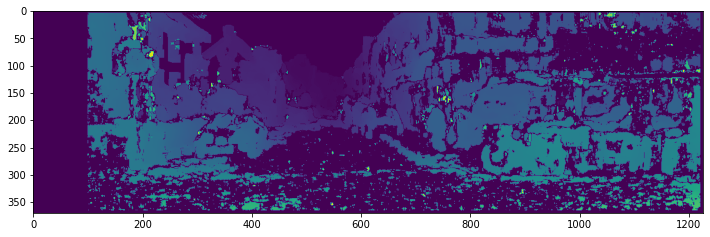

In [8]:
%matplotlib inline
l = cv2.imread(os.path.join(os.getenv("img_l_dir"), "0000000000.png"), 0)
r = cv2.imread(os.path.join(os.getenv("img_r_dir"), "0000000000.png"), 0)

disp = compute_disparity_map(l, r, verbose=True)
plt.figure(figsize=(12,6))
plt.imshow(disp)
plt.show()

Compute disparity map with stereoSGBM: 0.03897 secs


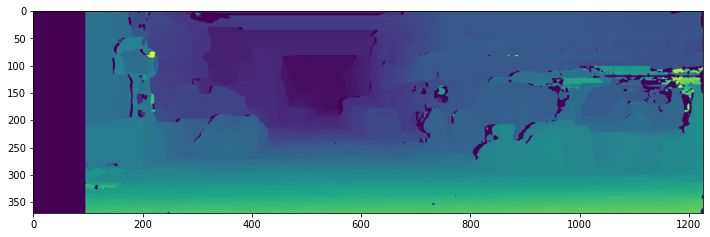

In [9]:
disp = compute_disparity_map(l, r, matcher='sgbm', verbose=True)
plt.figure(figsize=(12,6))
plt.imshow(disp)
plt.show()

We can see there us a gap of of the left side of the image where the right camera did not have matching information. This means that we should apply a mask when looking for features to match from one frame to the next so that we can use features which fall in the area of the picture for which we have depth information.

In [10]:
def decompose_projection(P: np.ndarray) -> tuple:
    k, r, t, *_ = cv2.decomposeProjectionMatrix(P)
    t = (t / t[3])[:3]  # non-homogeneous
    return k, r, t


def depth_map(disp: np.ndarray, k: np.ndarray, tl: np.ndarray, tr: np.ndarray) -> np.ndarray:
    f = k[0, 0]
    b = tr[0] - tl[0]

    disp = np.where((disp == 0.0) | (disp == -1.0), 0.1, disp)
    depth = depth = (f * b) / disp

    return depth

Let's compute the depth information from disparity map.

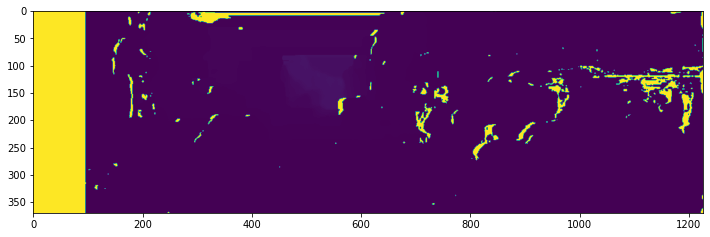

In [11]:
k0, r0, t0 = decompose_projection(p0)
k1, r1, t1 = decompose_projection(p1)

disp = compute_disparity_map(l, r, matcher='sgbm')
depth = depth_map(disp, k0, t0, t1)
plt.figure(figsize=(12, 6))
plt.imshow(depth)
plt.show()

## LiDAR Dataset Process
Process the LiDAR data from the dataset, which could be used for depth estimation and odometry correction later.

In [12]:
def pcl2img(pcl: np.ndarray, image: np.ndarray, Tr: np.ndarray, P0: np.ndarray) -> np.ndarray:
    ih, iw = image.shape[:2]

    pcl = pcl[pcl[:, 0] > 0]                        # filter out points behind lidar
    pcl = np.c_[pcl[:, :3], np.ones(pcl.shape[0])]  # homogeneous

    ## transform point cloud into camera coordiante and ignore point behind camera
    cam = Tr @ pcl.T
    cam = cam[:, cam[2] > 0]
    
    depth = cam[2].copy()
    cam /= depth
    cam = np.vstack([cam, np.ones(cam.shape[1])])
    
    pixel_coord = (P0 @ cam).T[:, :2].round(0).astype(np.int32)

    indices = np.where(
        (pixel_coord[:, 0] < iw) &
        (pixel_coord[:, 0] >= 0) &
        (pixel_coord[:, 1] < ih) &
        (pixel_coord[:, 1] >= 0)
    )
    pixel_coord, depth = pixel_coord[indices], depth[indices]

    depth_map = np.full((ih, iw), 3000, dtype=np.float32)
    depth_map[pixel_coord[:, 1], pixel_coord[:, 0]] = depth

    return depth_map

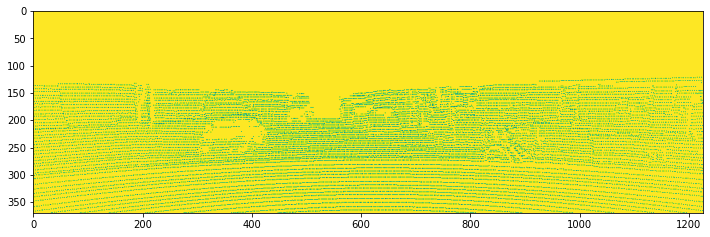

In [13]:
pcl0 = np.fromfile(
    os.path.join(os.getenv("lidar_dir"), "0000000000.bin"), 
    dtype=np.float32, count=-1
).reshape((-1, 4))
tr: np.ndarray = np.array(calib.loc["Tr:"]).reshape((3, 4))

depth_from_lidar = pcl2img(pcl0, l, tr, p0)
plt.figure(figsize=(12, 6))
plt.imshow(depth_from_lidar)
plt.show()

In [14]:
coverage = (
    depth_from_lidar[depth_from_lidar < depth_from_lidar.max()].size
    / depth_from_lidar.size
)
print(f"LiDAR coverage: {coverage * 100:.2f}%.")

LiDAR coverage: 4.38%.


## Feature Extraction and Matching
Extract the feature from image and matching between each frame to find the transformation relationship in camera poses between a sequences of frames.

In [15]:
def extract(
    image: np.ndarray, detector: Literal["orb", "sift"] = "sift"
) -> tuple[list[cv2.KeyPoint, np.ndarray]]:
    return (
        cv2.SIFT.create() if detector == "sift" else cv2.ORB.create()
    ).detectAndCompute(image, None)

In [16]:
def matching(
    des1: np.ndarray,
    des2: np.ndarray,
    detector: Literal['sift', 'orb'] = "sift",
    matcher: Literal['flann', 'bf'] = "bf",
    sort: bool = True,
    threshold: Optional[float] = None,
) -> list[cv2.DMatch]:

    if matcher == "bf":
        _matcher = cv2.BFMatcher.create(
            cv2.NORM_L2 if detector == "sift" else cv2.NORM_HAMMING2, 
            crossCheck=False
        )
    else:
        _matcher = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))

    matches = _matcher.knnMatch(des1, des2, 2)
    if threshold is not None:
        matches = [m for m, n in matches if m.distance <= threshold * n.distance]

    return sorted(matches, key=lambda x: x.distance) if sort else matches


def visualize(
    image1: np.ndarray,
    kp1: list,
    image2: np.ndarray,
    kp2: list,
    matches: list,
) -> None:
    _image = cv2.drawMatches(image1, kp1, image2, kp2, matches, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(_image)
    plt.show()

Number of matches with filtering: 866.


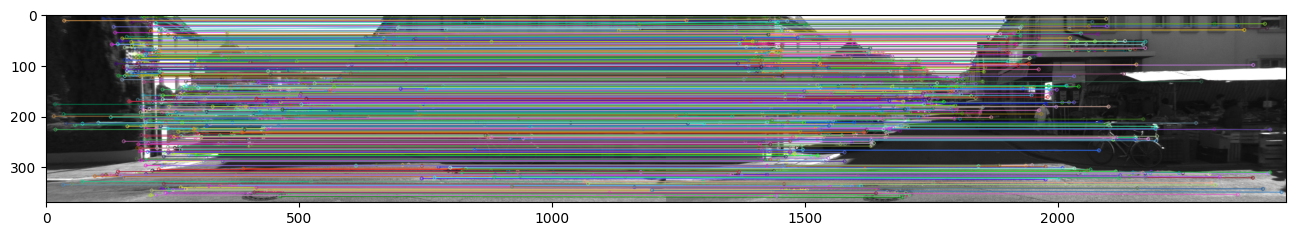

In [17]:
image1 = cv2.imread(os.path.join(os.getenv("img_l_dir"), "0000000000.png"), 0)
image2 = cv2.imread(os.path.join(os.getenv("img_l_dir"), "0000000001.png"), 0)

kp1, des1 = extract(image1)
kp2, des2 = extract(image2)
m = matching(des1, des2, matcher='bf', threshold=0.4)
print(f"Number of matches with filtering: {len(m)}.")
visualize(image1, kp1, image2, kp2, m)

Number of matches with filtering: 197.


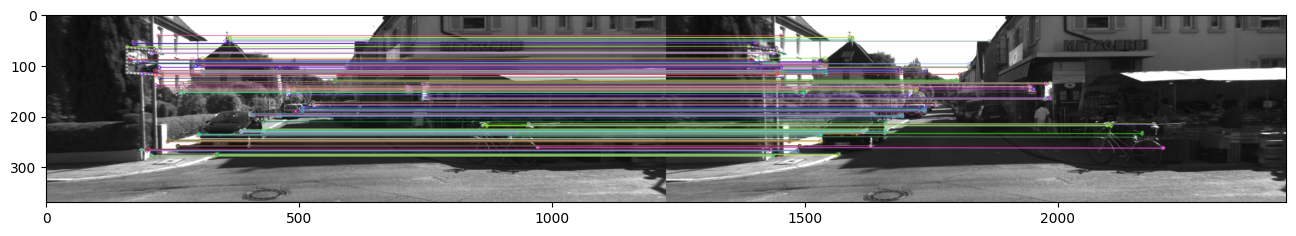

In [18]:
kp1, des1 = extract(image1, 'orb')
kp2, des2 = extract(image2, 'orb')
m = matching(des1, des2, detector='orb', matcher='bf', threshold=0.4)
print(f"Number of matches with filtering: {len(m)}.")
visualize(image1, kp1, image2, kp2, m)

We can see an informative graphic relating the quality of matches according to this metric below: 

<div align='center'>
    <img src="../assets/ratio_of_distance.png" width='600' alt='ratio of distance' />
</div>

We can see that there is a sweet spot found for this ratio between `0.4` and `0.5`, meaning that we want the distance to the closest match to be about half the distance to the second closest match in order to be certain that the feature is distinct, and not too similar to multiple features in the second image.